In [1]:
# Install yfinance to fetch stock data
!pip install yfinance --quiet

# Import basic libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Time Series Analysis

Choose company googl for time series analyses and data of 5 years

In [2]:
# Download GOOGL stock data for the last 5 years
data = yf.download('GOOGL', period='5y')

# Show the first 5 rows
data.head()

/tmp/ipython-input-2-3742140986.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download('GOOGL', period='5y')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL
Date,,,,,
2020-07-22,77.776054,77.881918,76.701498,77.321778,24482000
2020-07-23,75.385391,78.049415,74.979819,77.829731,33910000
2020-07-24,74.960930,75.319778,73.936078,74.512622,29902000
2020-07-27,76.015602,76.419680,75.165704,75.211927,27124000
2020-07-28,74.734299,75.845630,74.578730,75.795432,30910000


Visualize the Close Price Over Time

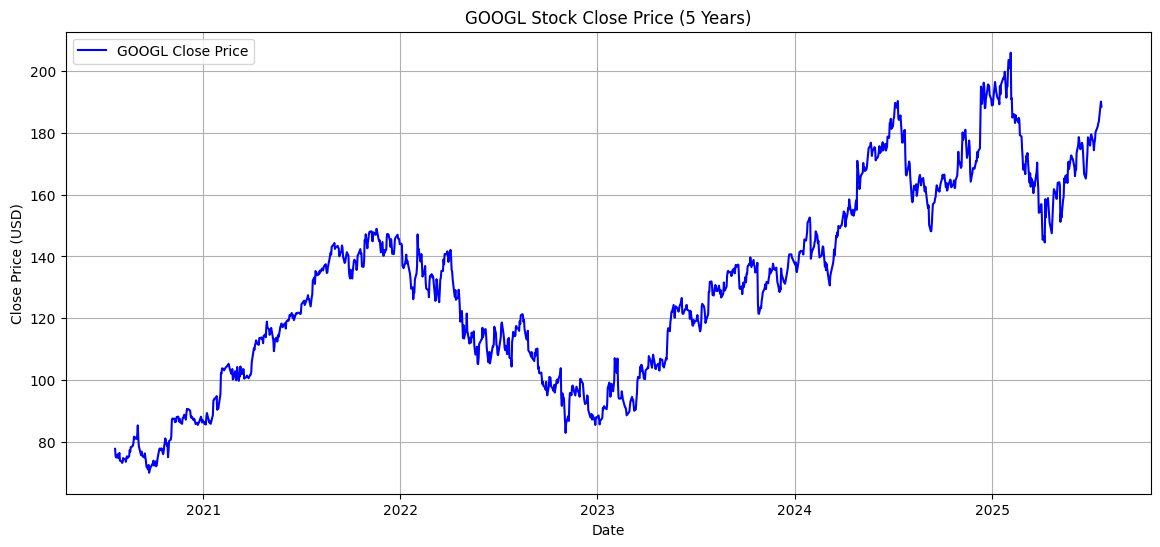

In [4]:
# Set plot size and style
plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='GOOGL Close Price', color='blue')
plt.title('GOOGL Stock Close Price (5 Years)')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

Rolling moving averages

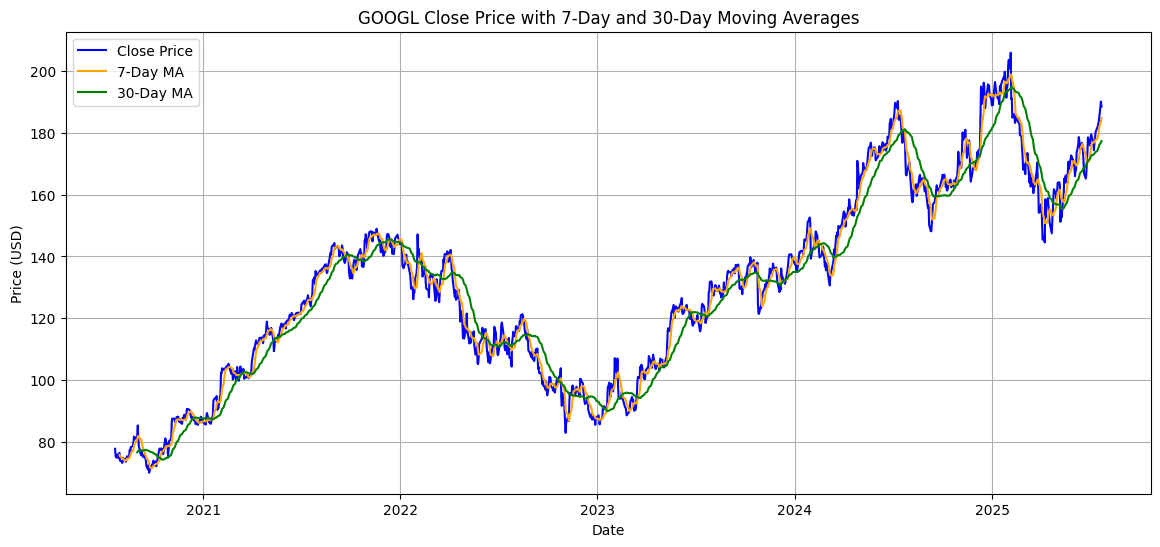

In [5]:
# Create 7-day and 30-day moving averages
data['MA_7'] = data['Close'].rolling(window=7).mean()
data['MA_30'] = data['Close'].rolling(window=30).mean()

# Plot Close Price with Moving Averages
plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(data['MA_7'], label='7-Day MA', color='orange')
plt.plot(data['MA_30'], label='30-Day MA', color='green')
plt.title('GOOGL Close Price with 7-Day and 30-Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

GOOGL stock had steady growth from 2020 to early 2022, then a decline through mid-2022 to early 2023.

After that, there’s a clear recovery and upward trend.

/tmp/ipython-input-6-620778324.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data['Close'].resample('M').mean()


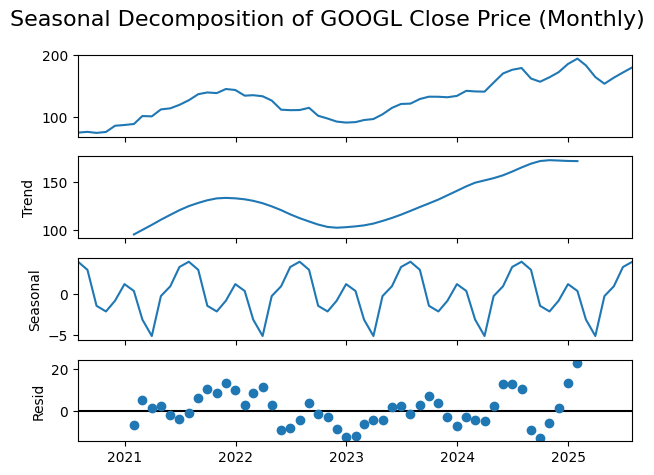

In [6]:
# Seasonal decomposition of the series (using seasonal_decompose)

# Use only 'Close' column and resample to monthly data (mean of each month)
monthly_data = data['Close'].resample('M').mean()

# Drop missing values if any
monthly_data = monthly_data.dropna()

# Apply seasonal decomposition (additive model)
decomposition = seasonal_decompose(monthly_data, model='additive')

# Plot the decomposition
decomposition.plot()
plt.suptitle('Seasonal Decomposition of GOOGL Close Price (Monthly)', fontsize=16)
plt.tight_layout()
plt.show()

Observed (top plot)
This is the original monthly average Close price for GOOGL.

Trend (2nd plot)

Shows the overall upward movement in GOOGL stock.

There’s a dip in 2022 and recovery after that.

Seasonal (3rd plot)

Shows repeating yearly patterns.

Example: some months regularly go slightly up or down each year.

Residual (bottom plot)

This is the random noise left after removing trend + seasonality.

Large spikes = unusual events or volatility in the market.

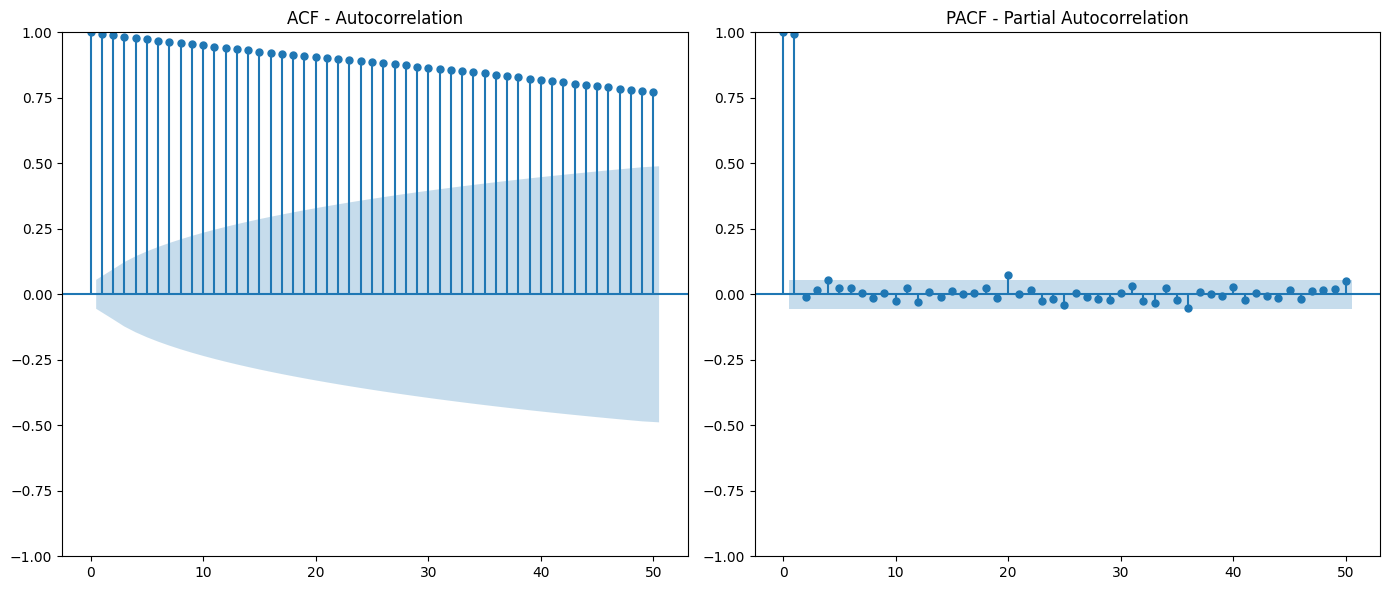

In [7]:
# - Plot ACF/PACF to understand lags and correlations.

# Plot ACF and PACF on 'Close' (original data)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(data['Close'].dropna(), lags=50, ax=plt.gca(), title='ACF - Autocorrelation')

plt.subplot(1, 2, 2)
plot_pacf(data['Close'].dropna(), lags=50, ax=plt.gca(), title='PACF - Partial Autocorrelation')

plt.tight_layout()
plt.show()

In [9]:
#A time series is stationary if its mean, variance, and autocorrelation stay constant over time.
# ARIMA models require stationary data to make accurate forecasts.

from statsmodels.tsa.stattools import adfuller

# ADF Test on Close prices
adf_result = adfuller(data['Close'].dropna())
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])

ADF Statistic: -1.1842659697006632
p-value: 0.6803272103838828


P value is greater than 0.05 so, The time series is not stationary, so we need to apply differencing to remove the trend and make it suitable for ARIMA modeling.

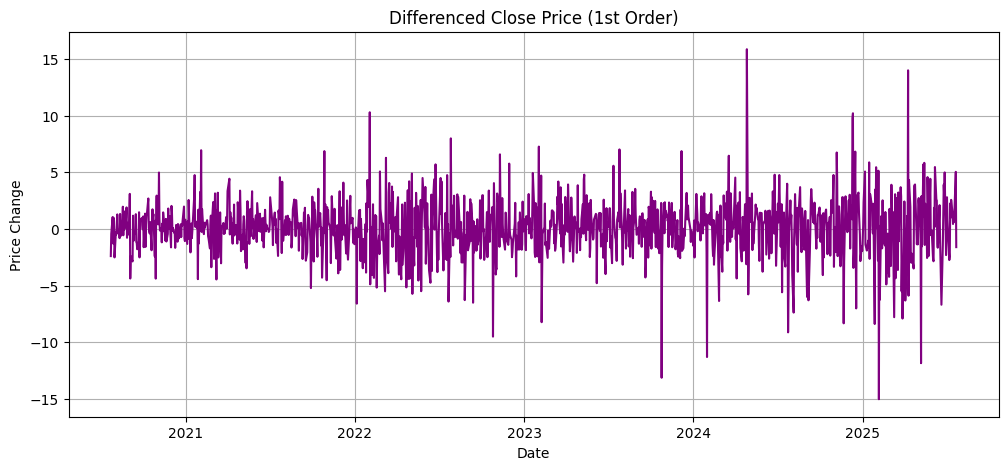

In [10]:
# Apply first differencing
data['Close_diff'] = data['Close'].diff()

# Drop missing value from the first row
data_diff = data['Close_diff'].dropna()

# Plot the differenced series
plt.figure(figsize=(12, 5))
plt.plot(data_diff, color='purple')
plt.title('Differenced Close Price (1st Order)')
plt.xlabel('Date')
plt.ylabel('Price Change')
plt.grid(True)
plt.show()

In [11]:
# ADF Test after differencing
adf_result_diff = adfuller(data_diff)
print("ADF Statistic (after differencing):", adf_result_diff[0])
print("p-value (after differencing):", adf_result_diff[1])

ADF Statistic (after differencing): -19.83530302942921
p-value (after differencing): 0.0


Now P value is leass than 0.05 means the differenced series is now stationary

# 2. ARIMA Benchmark

In [13]:
# Fit an appropriate ARIMA or SARIMA model on the Close price.

from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

# Try different (p, d, q) values and print AIC
for p in range(0, 4):
    for q in range(0, 4):
        try:
            model = ARIMA(data['Close'], order=(p, 1, q))  # d=1 because we differenced once
            model_fit = model.fit()
            print(f'ARIMA({p},1,{q}) - AIC: {model_fit.aic}')
        except:
            continue

ARIMA(0,1,0) - AIC: 5913.86594840372
ARIMA(0,1,1) - AIC: 5915.547423945217
ARIMA(0,1,2) - AIC: 5917.5428036507565
ARIMA(0,1,3) - AIC: 5910.840034868543
ARIMA(1,1,0) - AIC: 5915.547809912034
ARIMA(1,1,1) - AIC: 5916.807742217294
ARIMA(1,1,2) - AIC: 5914.478892130404
ARIMA(1,1,3) - AIC: 5910.02304070537
ARIMA(2,1,0) - AIC: 5917.547401174454
ARIMA(2,1,1) - AIC: 5919.547801403665
ARIMA(2,1,2) - AIC: 5909.959775403855
ARIMA(2,1,3) - AIC: 5910.755932148637
ARIMA(3,1,0) - AIC: 5911.311465621906
ARIMA(3,1,1) - AIC: 5909.27593073774
ARIMA(3,1,2) - AIC: 5910.443691229366
ARIMA(3,1,3) - AIC: 5911.864366210124


The lowest AIC is 5909.27 for ARIMA(3,1,1).

We'll now use this model.

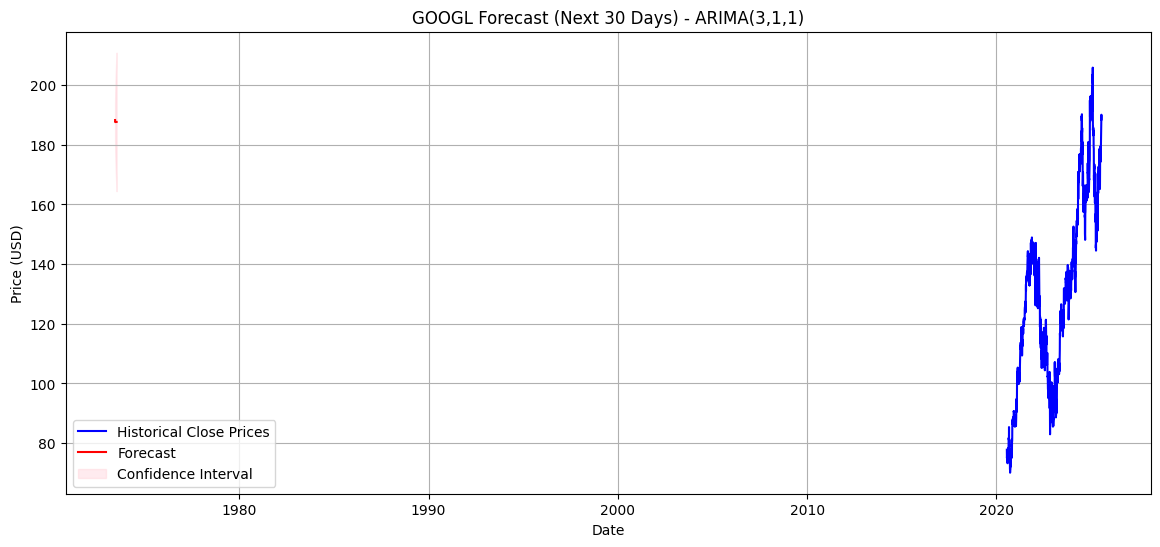

In [14]:
# Fit the best ARIMA model
model = ARIMA(data['Close'], order=(3, 1, 1))
model_fit = model.fit()

# Forecast next 30 days
forecast_result = model_fit.get_forecast(steps=30)
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# Create a plot of forecast
plt.figure(figsize=(14, 6))
plt.plot(data['Close'], label='Historical Close Prices', color='blue')
plt.plot(forecast_mean.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_mean.index,
                 conf_int.iloc[:, 0],
                 conf_int.iloc[:, 1],
                 color='pink', alpha=0.3, label='Confidence Interval')
plt.title('GOOGL Forecast (Next 30 Days) - ARIMA(3,1,1)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Actual values from the last 30 days of real data
actual = data['Close'][-30:]

# In-sample prediction for same period
prediction_result = model_fit.get_prediction(start=len(data)-30, end=len(data)-1)
predicted = prediction_result.predicted_mean

# Evaluation metrics
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mean_squared_error(actual, predicted))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 2.11
RMSE: 2.56


Selected model: ARIMA(3,1,1)

Why? It had the lowest AIC (5909.27), indicating the best fit among tested models.

Evaluation metrics:

MAE: 2.11

RMSE: 2.56

This means the model's forecasted Close prices are on average $2.11 off from actual prices, which is acceptable for financial time series.

# 3. Deep Learning Forecasting with LSTM

In [16]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Use just the 'Close' column
close_data = data['Close'].values.reshape(-1, 1)

# Normalize data between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(close_data)

# Set sliding window size
window_size = 30

# Create input-output pairs
X = []
y = []
for i in range(window_size, len(scaled_data)):
    X.append(scaled_data[i - window_size:i])
    y.append(scaled_data[i])

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1226, 30, 1)
y shape: (1226, 1)


In [17]:
# Split into train (80%) and test (20%)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])

Train size: 980
Test size: 246


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))  # Output layer

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.1068 - val_loss: 0.0030
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - val_loss: 0.0031
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0023 - val_loss: 0.0056
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 0.0092
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 0.0066
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 0.0051
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 0.0034
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 0.0039
Epoch 9/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - val_loss: 0.0036
Epoch 10/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 11/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0010 - val_loss: 0.0029
Epoch 12/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.8377e-04 - v

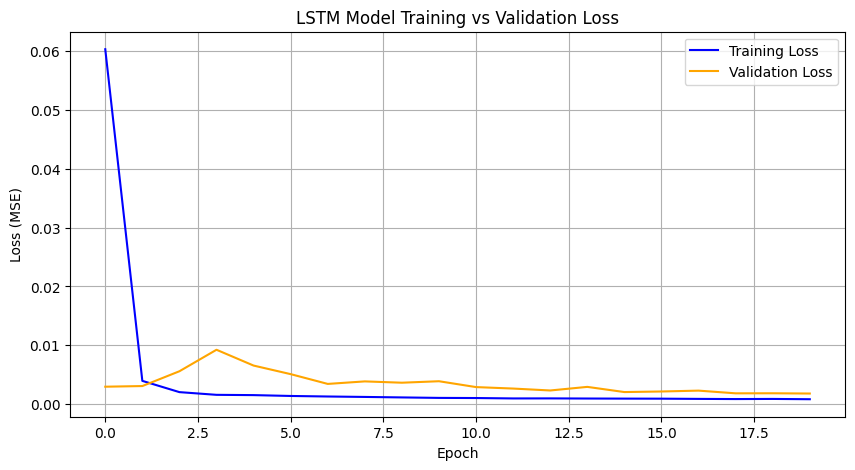

In [19]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('LSTM Model Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step


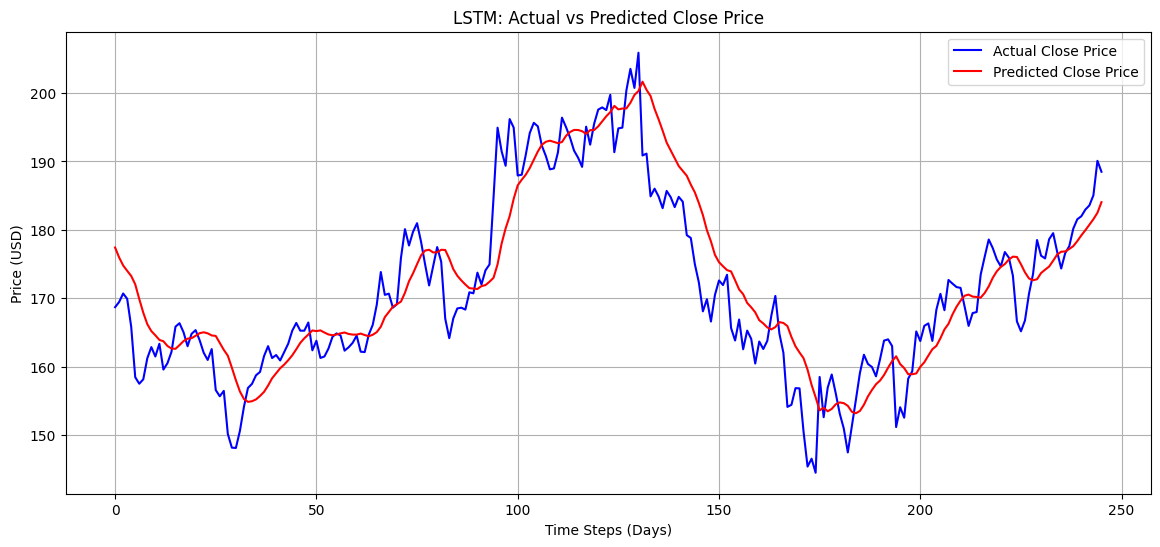

In [20]:
# Predict on test data
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test)

# Plot actual vs predicted
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, label='Actual Close Price', color='blue')
plt.plot(y_pred, label='Predicted Close Price', color='red')
plt.title('LSTM: Actual vs Predicted Close Price')
plt.xlabel('Time Steps (Days)')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_lstm = mean_absolute_error(y_test_actual, y_pred)
rmse_lstm = np.sqrt(mean_squared_error(y_test_actual, y_pred))

print(f"LSTM MAE: {mae_lstm:.2f}")
print(f"LSTM RMSE: {rmse_lstm:.2f}")

LSTM MAE: 4.54
LSTM RMSE: 5.78


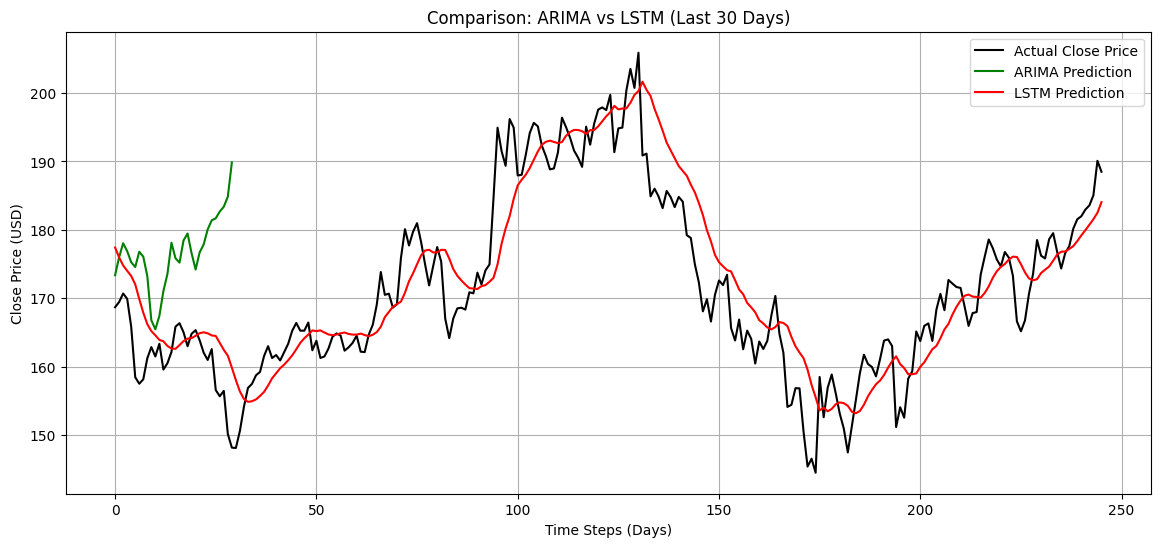

In [22]:
# compare both

plt.figure(figsize=(14, 6))

# Plot actual
plt.plot(y_test_actual, label='Actual Close Price', color='black')

# Plot ARIMA predictions
plt.plot(predicted.values, label='ARIMA Prediction', color='green')

# Plot LSTM predictions
plt.plot(y_pred, label='LSTM Prediction', color='red')

plt.title('Comparison: ARIMA vs LSTM (Last 30 Days)')
plt.xlabel('Time Steps (Days)')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

The ARIMA model gave more accurate short-term predictions (MAE: 2.11, RMSE: 2.56) compared to the LSTM model (MAE: 4.54, RMSE: 5.78). This is visible in the plot where ARIMA closely follows the actual price trend in the near future. LSTM struggled to capture recent changes despite learning long-term patterns. Overall, for this stock data, ARIMA outperformed LSTM in both accuracy and prediction stability.